In [218]:
%pip install -q -U gym
%pip install -q -U gym[classic_control, box2d, atari, accept-rom-license]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'gym[classic_control,'


In [283]:
import gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from IPython.display import HTML
from collections import deque
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import MSE

### This is a simple notebook trying to implement reinforcement learning for the Blackjack card game using basic policy without deep learning and policy using Neural Network. Read more about the used environment here: https://www.gymlibrary.dev/environments/toy_text/blackjack/

In [220]:
env = gym.make("Blackjack-v1", natural=True, sab=False)
obs = env.observation_space
print(obs)

Tuple(Discrete(32), Discrete(11), Discrete(2))


The observation space is: player's current sum, dealer's value of one showing card, whether the player holds a usable ace (0 or 1).

In [221]:
env.action_space

Discrete(2)

The action space is 0 for sticking with the card, 1 for drawing next card.

In [222]:
env.reward_range

(-inf, inf)

Rewards are as follows: -1 for loose, 0 for draw, 1 for win.

Here is a simple game where we draw cards twice and then we stick. Unfortunately it's a loss.

In [223]:
obs, info = env.reset(seed=27)
stick=0
drawMore=1
print(f"INITIAL STATE: Player's sum: {obs[0]}, Dealer's face up card: {obs[1]}, Player has ace: {obs[2]}")

for step in range(3):
    action = drawMore
    if step == 2:
        action = stick
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Player's sum: {obs[0]}, Dealer's face up card: {obs[1]}, Player has ace: {obs[2]}, Reward for this step: {reward}, Done? {terminated}")


INITIAL STATE: Player's sum: 8, Dealer's face up card: 1, Player has ace: False
Player's sum: 10, Dealer's face up card: 1, Player has ace: False, Reward for this step: 0.0, Done? False
Player's sum: 18, Dealer's face up card: 1, Player has ace: False, Reward for this step: 0.0, Done? False
Player's sum: 18, Dealer's face up card: 1, Player has ace: False, Reward for this step: -1.0, Done? True


#### Below is a basic policy which states that we should stick with the cards when the current sum is 17 or more and draw more cards otherwise.

In [264]:
def basic_policy(obs):
    playersSum = obs[0]
    if playersSum >=17:
        return 0 # when players sum is 17 or higher, we choose to stick with the cards
    else:
        return 1 # otherwise we draw the next card

In [265]:
totals = []
episodesCount = 1000
for episode in range(episodesCount):
    episode_rewards = 0
    obs, info = env.reset(seed=episode) #different seeds everytime
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        episode_rewards += reward
        if terminated or truncated:
            break
    totals.append(episode_rewards)

In [266]:
winCount = totals.count(1.0) + totals.count(1.5)
winRate = round((winCount/episodesCount)*100, 2)
print("="*60)
print(f"\t>>> Win rate using basic policy: {winRate}% <<<")
print("="*60)




	>>> Win rate using basic policy: 41.2% <<<


#### Game using Neural Network

In [227]:
input_shape = [3] #observation space shape - player's sum, dealer's face up card, player has ace
n_outputs = 2 # 2 outputs - 2 possible actions
model = Sequential([
    Input(shape=input_shape),
    Dense(32, activation = "relu"),
    Dense(32, activation = "relu"),
    Dense(n_outputs)
])

In [228]:
def normalize_state(state):
    """Normalize the state values to [0,1] range"""
    player_sum, dealer_card, usable_ace = state
    return np.array([
        player_sum / 31.0,  # max possible sum
        dealer_card / 10.0, # max dealer card
        float(usable_ace)
    ])

In [229]:
def epsilon_greedy_policy(state, epsilon = 0): #choose random action with probability epsilon, otherwise choose best
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) #random action
    else:
        state = np.array(state)
        Q_values = model.predict(state[np.newaxis], verbose = 0)[0]
        return Q_values.argmax()

In [230]:
replay_buffer = deque(maxlen=2000)

In [231]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [np.array([experience[field_index] for experience in batch]) for field_index in range(6)]
    #the six are states, actions, rewards, next_states, dones, truncateds

In [232]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    next_state = normalize_state(next_state)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [233]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

In [271]:
batch_size = 32
discount_factor = 0.8
optimizer = Nadam(learning_rate = 0.05)
loss_fn = MSE

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose = 0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)
    target_Q_values = rewards + runs*discount_factor*max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [235]:
def getWinRate(rewards, episodesCount):
    winCount = rewards.count(1.0) + rewards.count(1.5)
    winRate = round((winCount/episodesCount)*100, 2)
    return winRate

In [ ]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
episodesCount = 5000    

for episode in range(episodesCount): #long-running cell, just under an hour on A100
    obs, info = env.reset()
    obs = normalize_state(obs)
    episode_rewards=0
    for step in range(200):
        epsilon = max(1-episode/500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        episode_rewards += reward
        if done or truncated:
            break

    rewards.append(episode_rewards)
    winRate = getWinRate(rewards, episode+1)
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}, Win rate: {winRate}%",
          end="")

    if episode > 50:
        training_step(batch_size)

Episode: 1000, Steps: 3, eps: 0.010, Win rate: 38.7%

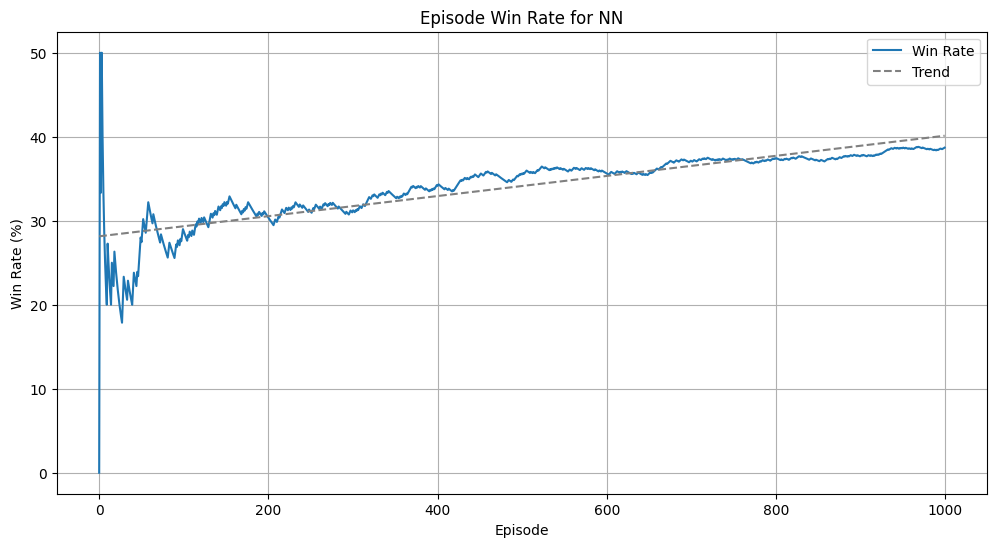

In [295]:
plt.figure(figsize=(12, 6))
winRates = [getWinRate(rewards[:i], i+1) for i in range(episodesCount)]
plt.plot(winRates, label='Win Rate')

# Add a dotted trend line
x = np.arange(episodesCount)
trend = np.poly1d(np.polyfit(x, winRates, 1))(x)
plt.plot(x, trend, '--', color='gray', label='Trend')

plt.xlabel('Episode')
plt.ylabel('Win Rate (%)')
plt.title('Episode Win Rate for NN')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def evaluate_agent(agent, episodes=1000):
    wins = 0
    draws = 0
    losses = 0
    
    for _ in range(episodes):
        state = env.reset()[0]
        state = normalize_state(state)
        done = False
        
        while not done:
            state = np.array(state)
            action = agent.predict(state[np.newaxis], verbose = 0)[0].argmax()
            next_state, reward, done, _, _ = env.step(action)
            state=next_state
            state = normalize_state(next_state)
            
        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1
    
    print(f"\nResults over {episodes} episodes:")
    print(f"Wins: {wins} ({wins/episodes*100:.1f}%)")
    print(f"Draws: {draws} ({draws/episodes*100:.1f}%)")
    print(f"Losses: {losses} ({losses/episodes*100:.1f}%)")

    return round(wins/episodes*100,2), round(draws/episodes*100,2), round(losses/episodes*100,2)
# Evaluate the trained agent
wins, draws, losses = evaluate_agent(model)




Results over 100 episodes:
Wins: 41 (41.0%)
Draws: 6 (6.0%)
Losses: 53 (53.0%)


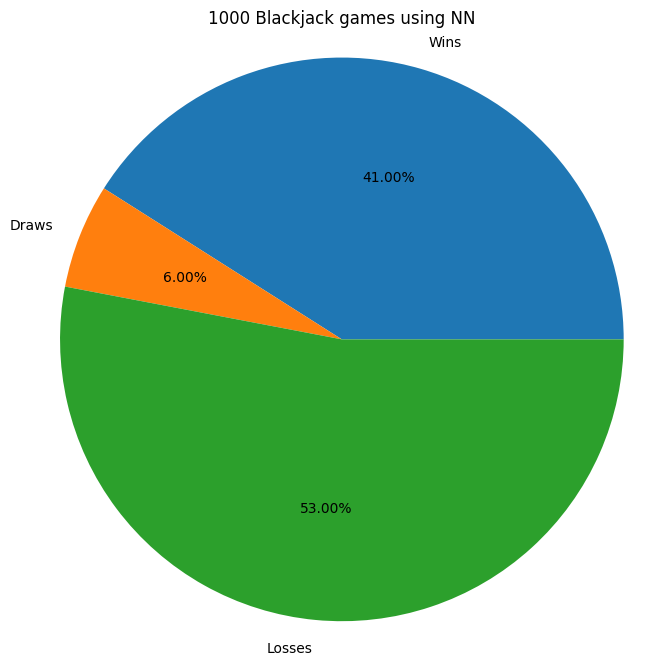

In [300]:
labels = ['Wins', 'Draws', 'Losses']
values = [wins, draws, losses]

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(values, labels=labels, autopct='%1.2f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is circular.
ax.set_title('1000 Blackjack games using NN')
plt.show()